In [12]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import numpy as np

## 이미지 전처리 및 Load

In [3]:
data_path = './catanddog/train/'

transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor()
                ]) # 1

train_dataset = torchvision.datasets.ImageFolder(
                data_path,
                transform=transform
                ) # 2

train_loader = torch.utils.data.DataLoader(
                train_dataset,
                batch_size=32,
                num_workers=8, 
                shuffle=True
                ) # 3

print(len(train_dataset))

385


1. torchvision.transform은 이미지 데이터를 변환하여 모델의 입력으로 사용할 수 있게 변환해 준다.
    * Resize : 이미지의 크기를 조정. 합성곱층을 통과하기 위해 이미지 크기를 조정하는 전처리
    *  RandomResizedCrop : 이미지를 랜덤한 크기 및 비율로 자른다. 데이터 확장 용도로 사용
    * RandomHorizontalFlip ; 이미지를 랜덤하게 수평으로 뒤집는다.
    * ToTensor : 이미지를 텐서로 변환
2. datasets.ImageFloder는 데이터로더가 데이터를 불러올 대상과 방법을 정의한다.
3. 데이터로더는 데이터를 불러오는 부분으로 앞에서 성의한 ImageFolder를 데이터로더에 할당하는데, 이때 한번에 불러올 데이터양을 결정하는 batch_size를 지정한다.

In [6]:
len(train_loader)

13

### 학습에 사용될 이미지 출력

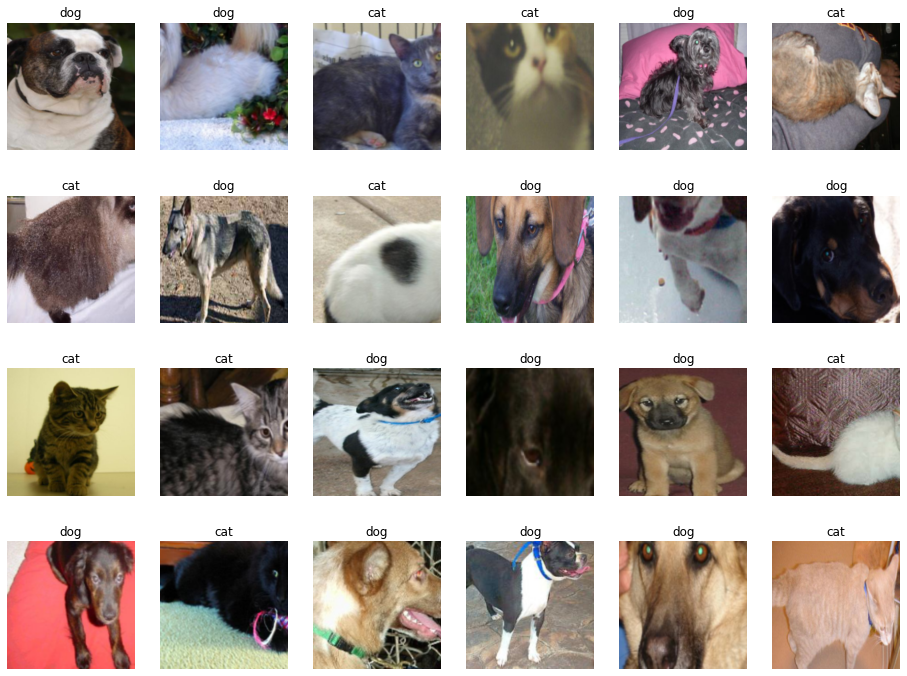

In [13]:
samples, labels = iter(train_loader).next() # 1
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16, 24))
for i in range(24): # 24개의 이미지 출력
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0))) # 2
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

1. iterator를 사용하려면 iter()와 next()가 필요하다. iter()는 전달된 데이터의 반복자를 꺼내 반환하며, next()는 그 반복자가 다음에 출력해야 할 요소를 반환한다. 즉, iter()로 반복자를 구하고 그 반복자를 next()에 전달하여 차례대로 꺼낼 수 있다.

## 사전 훈련된 모델 받기

In [28]:
resnet18 = models.resnet18(pretrained=True)

### 사전 훈련된 모델의 파라미터 학습 유무 지정

In [29]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)

In [30]:
resnet18.fc = nn.Linear(512, 2)

### 모델의 파라미터값 확인

In [31]:
for name, param in resnet18.named_parameters(): # model.named_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0410, -0.0435, -0.0348,  ..., -0.0040,  0.0370,  0.0346],
        [ 0.0328,  0.0437, -0.0337,  ...,  0.0189, -0.0425,  0.0311]])
fc.bias tensor([-0.0163,  0.0112])


### 모델 객체 생성 및 손실 함수 정의

In [32]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False # 합성곱층 가중치 고정
    
model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True # fc층을 학습
    
optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 모델 학습을 위한 함수 생성

In [33]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('./catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

### 파라미터 학습 결과를 옵티마이저에 전달

In [35]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param) # 파라미터 학습 결과를 저장
        print('\t', name)
        
optimizer = optim.Adam(params_to_update) # 학습결과를 옵티마이저에 전달

	 fc.weight
	 fc.bias


## 모델 학습

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hidt = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.6165 Acc: 0.6545

Epoch 1/12
----------
Loss: 0.3841 Acc: 0.8468

Epoch 2/12
----------
Loss: 0.3064 Acc: 0.8805

Epoch 3/12
----------
Loss: 0.2551 Acc: 0.9039

Epoch 4/12
----------
Loss: 0.2457 Acc: 0.8987

Epoch 5/12
----------
Loss: 0.2631 Acc: 0.8857

Epoch 6/12
----------
Loss: 0.2865 Acc: 0.8727

Epoch 7/12
----------
Loss: 0.1915 Acc: 0.9351

Epoch 8/12
----------
Loss: 0.1955 Acc: 0.9221

Epoch 9/12
----------
Loss: 0.2113 Acc: 0.9143

Epoch 10/12
----------
Loss: 0.2067 Acc: 0.9039

Epoch 11/12
----------
Loss: 0.2194 Acc: 0.8909

Epoch 12/12
----------
Loss: 0.1952 Acc: 0.9117

Training complete in 0m 44s
Best Acc: 0.935065


### 테스트 데이터 호출 및 전처리

In [37]:
test_path = './catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


## 테스트 데이터 평가 함수 생성

In [39]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('./catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [40]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['./catanddog\\00.pth', './catanddog\\01.pth', './catanddog\\02.pth', './catanddog\\03.pth', './catanddog\\04.pth', './catanddog\\05.pth', './catanddog\\06.pth', './catanddog\\07.pth', './catanddog\\08.pth', './catanddog\\09.pth', './catanddog\\10.pth', './catanddog\\11.pth', './catanddog\\12.pth']
Loading model ./catanddog\00.pth


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!